# Introduction

This project applies time-series forecasting techniques to analyze and predict the spread of COVID-19 in three major countries: India, the United States, and Brazil. Historical data on confirmed cases, recoveries, and deaths are cleaned and processed to identify trends and patterns over time.

The Facebook Prophet model is used to generate short-term forecasts of COVID-19 case counts. Prophet is well suited for epidemiological data because it can handle non-linear trends, missing values, and sudden changes. Forecasts are generated for a 7-day horizon and visualized with confidence intervals to reflect prediction uncertainty.

Model performance is evaluated using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), allowing comparison across countries. Results show that India achieves the lowest prediction errors, while the United States exhibits higher variability due to sudden case surges.

Overall, this project demonstrates how time-series forecasting can support pandemic monitoring and decision-making by providing meaningful insights into future COVID-19 trends.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Project Objectives

The main objectives of this project are to:

*   Analyze the historical spread of COVID-19 in India, the United States, and Brazil using time-series data
*   Identify trends and patterns in confirmed cases, recoveries, and deaths
*   Apply the Facebook Prophet model to generate short-term forecasts
*   Evaluate forecasting performance using RMSE and MAE
*   Compare prediction accuracy across different countries
*   Provide insights that can assist in public health planning and monitoring

## Dataset Details

The dataset contains daily COVID-19 statistics for multiple countries, including India, the United States, and Brazil. It includes the following key features:

*   Date – Reporting date
*   Confirmed Cases – Total number of confirmed COVID-19 cases
*   Recovered Cases – Total number of recovered patients
*   Deaths – Total number of fatalities

The data has been preprocessed to handle missing values, remove inconsistencies, and ensure compatibility with time-series forecasting. For this project, the data is formatted for use with the Prophet model, with dates as the time index and case counts as the target variables.

Although the dataset covers many countries worldwide, this project focuses specifically on analyzing trends and making predictions for India, the United States, and Brazil.

This dataset provides a reliable foundation for exploring pandemic trends and building predictive models.

### 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 2. Load Dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Covid 19/covid_19_clean_complete.csv')
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


### 3. Data Cleaning & Validation

In [4]:
df.rename(columns={"Province/State":"State", "Country/Region":"Country"}, inplace=True)

In [5]:
df["Date"] = pd.to_datetime(df["Date"])

In [6]:
numeric_cols = ["Confirmed","Deaths","Recovered"]

In [7]:
df[numeric_cols] = df[numeric_cols].fillna(0)

In [8]:
df = df[(df[numeric_cols] >= 0).all(axis=1)]

In [9]:
df = df.sort_values("Date")

In [10]:
print("Date Range:", df["Date"].min(), "to", df["Date"].max())

Date Range: 2020-01-22 00:00:00 to 2020-07-27 00:00:00


In [11]:
print("Missing Values:\n", df.isna().sum())

Missing Values:
 State         34404
Country           0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
WHO Region        0
dtype: int64


In [12]:
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


### 4. Feature Engineering

**Active cases (Active):** Calculated as Confirmed - Deaths - Recovered to represent the current number of ongoing COVID-19 cases.

**Daily new cases (New_Cases):** Computed as the day-to-day difference in confirmed cases per country, with negative values clipped to zero.

**Daily new deaths (New_Deaths):** Computed as the day-to-day difference in deaths per country, with negative values clipped to zero.

**7-day moving averages (MA7_Cases, MA7_Deaths):** Smoothed trends for new cases and deaths per country using a 7-day rolling average to reduce daily fluctuations and highlight trends.

#### Active Cases

In [13]:
df["Active"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]

#### Daily Changes

In [14]:
df = df.sort_values(["Country","Date"])
df["New_Cases"] = df.groupby("Country")["Confirmed"].diff().clip(lower=0)

In [15]:
df["New_Deaths"] = df.groupby("Country")["Deaths"].diff().clip(lower=0)

#### 7-Day Rolling Averages

In [16]:
df["MA7_Cases"] = df.groupby("Country")["New_Cases"].transform(lambda x: x.rolling(7).mean())
df["MA7_Deaths"] = df.groupby("Country")["New_Deaths"].transform(lambda x: x.rolling(7).mean())

In [17]:
df.head()

,State,Country,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region,New_Cases,New_Deaths,MA7_Cases,MA7_Deaths
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean,NaN,NaN,NaN,NaN
261,NaN,Afghanistan,33.93911,67.709953,2020-01-23,0,0,0,0,Eastern Mediterranean,0.0,0.0,NaN,NaN
522,NaN,Afghanistan,33.93911,67.709953,2020-01-24,0,0,0,0,Eastern Mediterranean,0.0,0.0,NaN,NaN
783,NaN,Afghanistan,33.93911,67.709953,2020-01-25,0,0,0,0,Eastern Mediterranean,0.0,0.0,NaN,NaN
1044,NaN,Afghanistan,33.93911,67.709953,2020-01-26,0,0,0,0,Eastern Mediterranean,0.0,0.0,NaN,NaN


### 5. Global Aggregation

This code performs global aggregation and smoothing of COVID-19 data. It first sums key metrics (Confirmed, Deaths, Recovered, Active, New Cases, New Deaths) across all countries for each date. Then, it calculates smoothed trends of new cases using a 7-day moving average (MA7_New_Cases) and a 7-day exponential moving average (EMA7_New_Cases) to highlight short-term trends while reducing daily fluctuations.

In [18]:
global_df = df.groupby("Date")[["Confirmed","Deaths","Recovered","Active","New_Cases","New_Deaths"]].sum().reset_index()

#### Smoothed Global Trends

In [19]:
global_df["MA7_New_Cases"] = global_df["New_Cases"].rolling(7).mean()
global_df["EMA7_New_Cases"] = global_df["New_Cases"].ewm(span=7, adjust=False).mean()

### 6. Epidemiological Metrics

**Infection Rate:** The percentage of previously active cases that became new cases, indicating the speed of disease spread.

**Death Rate:** The percentage of previously active cases that resulted in deaths, reflecting disease severity.

**Case Fatality Rate (CFR):** The proportion of total confirmed cases that have died, measuring overall lethality.

**Growth Factor:** The ratio of new cases today to new cases yesterday, showing whether the outbreak is accelerating (>1) or slowing (<1).

**MA7_*:** A 7-day moving average of the above metrics to smooth out daily fluctuations for trend analyis

In [20]:
prev_active = global_df["Active"].shift(1)

global_df["Infection_Rate"] = (global_df["New_Cases"] / prev_active) * 100
global_df["Death_Rate"] = (global_df["New_Deaths"] / prev_active) * 100
global_df["CFR"] = (global_df["Deaths"] / global_df["Confirmed"]) * 100
global_df["Growth_Factor"] = global_df["New_Cases"] / global_df["New_Cases"].shift(1)

# Smooth them
for col in ["Infection_Rate","Death_Rate","Growth_Factor"]:
    global_df["MA7_"+col] = global_df[col].rolling(7).mean()


### 7. Global Trend Visualization



#### Global Pandemic Phases

This graph shows the global COVID-19 trend using 7-day moving averages to smooth daily fluctuations. It compares new cases, active cases, and deaths over time, allowing us to identify different phases of the pandemic such as rapid spread, peak infection periods, and decline. The smoothing helps reveal long-term patterns and global waves more clearly.

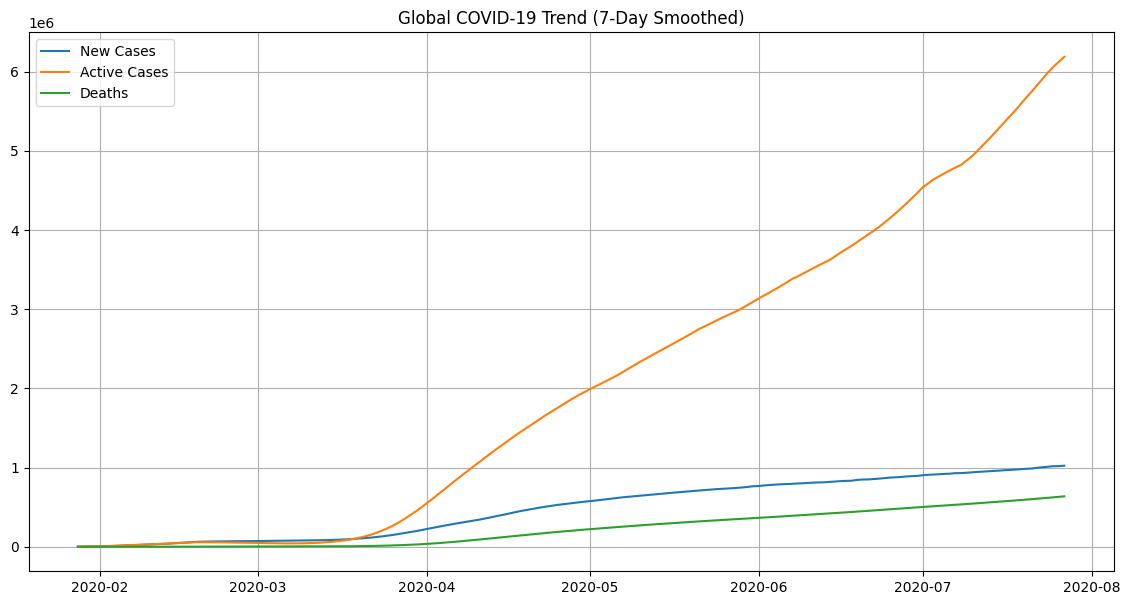

In [21]:
plt.figure(figsize=(14,7))
plt.plot(global_df["Date"], global_df["MA7_New_Cases"], label="New Cases")
plt.plot(global_df["Date"], global_df["Active"].rolling(7).mean(), label="Active Cases")
plt.plot(global_df["Date"], global_df["Deaths"].rolling(7).mean(), label="Deaths")
plt.legend()
plt.title("Global COVID-19 Trend (7-Day Smoothed)")
plt.grid(True)
plt.show()


### 8. Infection vs Recovery

This graph compares the trend of new COVID-19 infections and recoveries over time. The infection line shows the 7-day moving average of new cases, while the recovery line shows the 7-day average of daily recovered patients. Together, they illustrate how the spread of the disease relates to the pace of recovery, helping identify whether the outbreak is accelerating or coming under control.

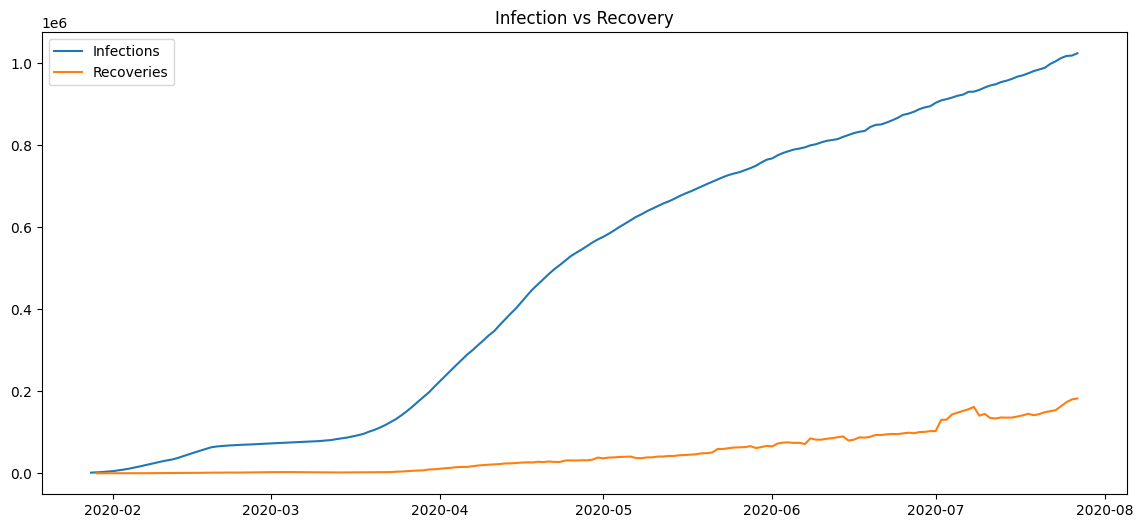

In [22]:
plt.figure(figsize=(14,6))
plt.plot(global_df["Date"], global_df["MA7_New_Cases"], label="Infections")
plt.plot(global_df["Date"], global_df["Recovered"].diff().rolling(7).mean(), label="Recoveries")
plt.legend()
plt.title("Infection vs Recovery")
plt.show()

### 9. Growth Factor

The growth factor shows how fast COVID cases are changing from one day to the next. It is calculated as today’s new cases divided by yesterday’s new cases, and here it is smoothed using a 7-day moving average (MA7) to reduce daily fluctuations.

*   Growth factor > 1 → Cases are increasing
*   Growth factor = 1 → Cases are stable
*   Growth factor < 1 → Cases are decreasing

The red dashed line at 1 marks the point where the outbreak shifts from growing to shrinking. When the curve stays below this line, it indicates that the spread is coming under control.

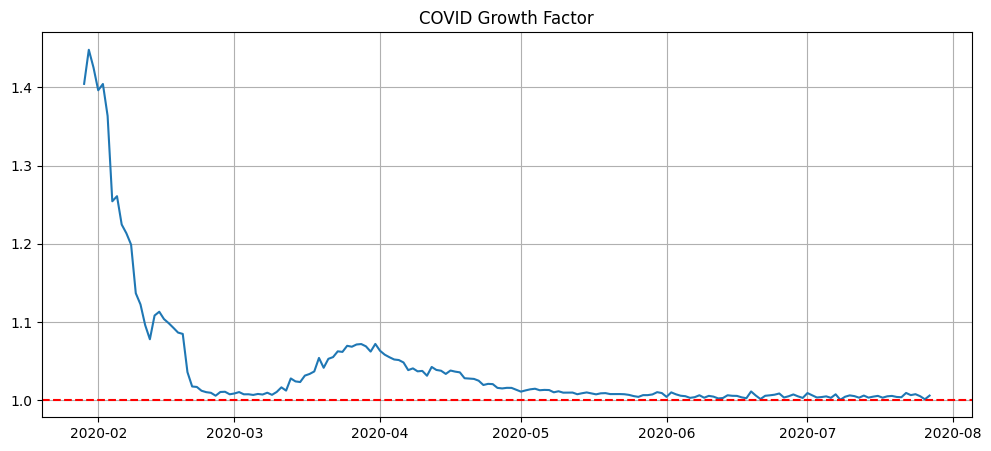

In [23]:
plt.figure(figsize=(12,5))
plt.plot(global_df["Date"], global_df["MA7_Growth_Factor"])
plt.axhline(1, linestyle="--", color="red")
plt.title("COVID Growth Factor")
plt.grid()
plt.show()


### 10. Country Comparison

This chart compares the top five countries with the highest total confirmed COVID-19 cases by plotting their 7-day moving average of daily new cases over time.

The smoothing removes daily fluctuations, making it easier to see overall trends, peaks, and waves of infection in each country and to compare how the outbreaks evolved across them.

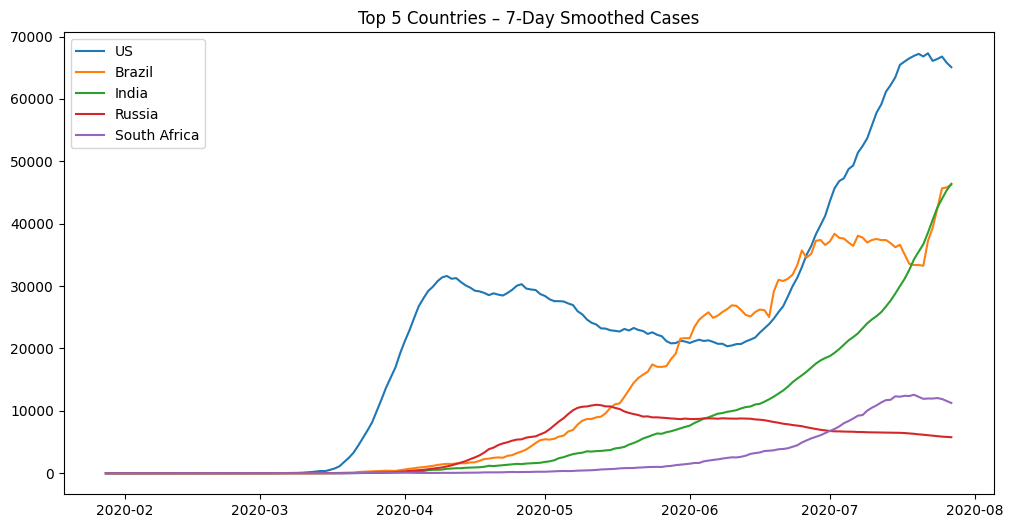

In [24]:
top5 = df.groupby("Country")["Confirmed"].max().sort_values(ascending=False).head(5).index

plt.figure(figsize=(12,6))
for c in top5:
    temp = df[df["Country"]==c].groupby("Date")["New_Cases"].sum().rolling(7).mean()
    plt.plot(temp, label=c)

plt.legend()
plt.title("Top 5 Countries – 7-Day Smoothed Cases")
plt.show()


### 11. Seven Day Forecast Using EMA Growth

This chart projects COVID-19 cases for the next 7 days using the latest EMA-smoothed growth rate.
First, a 7-day Exponential Moving Average (EMA) of new cases is used to capture the current trend. The percentage change of this EMA gives a recent growth rate, which is then applied forward each day to estimate future cases.

The solid line shows the historical smoothed trend, while the red dashed line represents the forecast. If the dashed line rises, cases are expected to grow; if it falls, cases are expected to decline. This provides a quick, trend-based outlook assuming current conditions remain the same.

In [25]:
global_df["Growth_Rate"] = global_df["EMA7_New_Cases"].pct_change()

latest_cases = global_df["EMA7_New_Cases"].iloc[-1]
latest_growth = global_df["Growth_Rate"].iloc[-1]

forecast = []
current = latest_cases

for i in range(7):
    current *= (1 + latest_growth)
    forecast.append(current)

future_dates = pd.date_range(global_df["Date"].iloc[-1] + pd.Timedelta(days=1), periods=7)


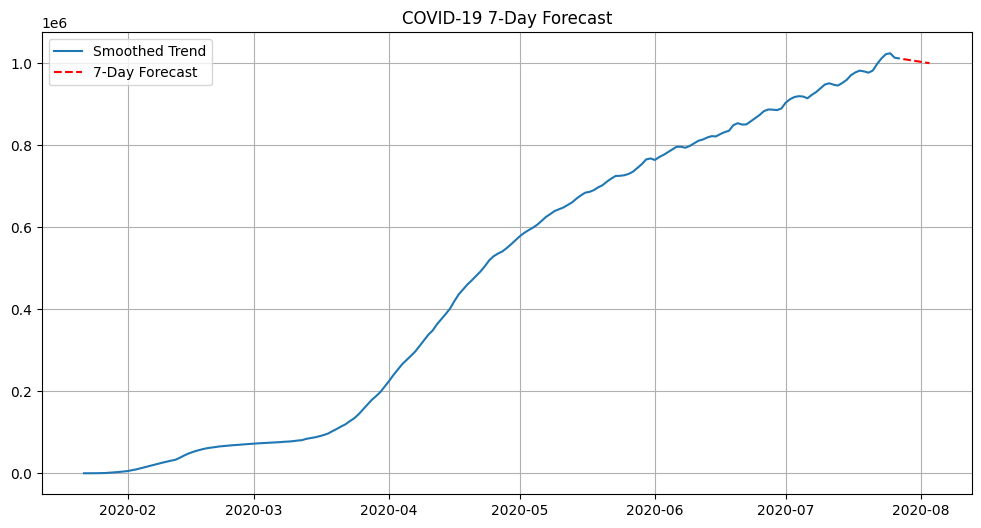

In [26]:
plt.figure(figsize=(12,6))
plt.plot(global_df["Date"], global_df["EMA7_New_Cases"], label="Smoothed Trend")
plt.plot(future_dates, forecast, 'r--', label="7-Day Forecast")
plt.legend()
plt.title("COVID-19 7-Day Forecast")
plt.grid()
plt.show()


This following is a complete, end-to-end time-series forecasting pipeline using Facebook Prophet that:

Analyzes infection, recovery & death trends

Visualizes historical + forecasted curves

Predicts next 7 days COVID cases

## * Facebook Prophet *

Facebook Prophet is an open-source time-series forecasting tool developed by Meta that predicts future values from past data, especially when there are trends, seasonal patterns, and sudden changes. It is widely used for forecasting sales, website traffic, disease spread, and demand, and is especially useful for COVID-19 data because it can handle missing and noisy values, detect sudden changes like lockdowns or vaccination drives, and give reliable predictions even with limited data.

## Prepare Time Series Data

### 1. Aggregate global data

This step aggregates the dataset by date, summing the total number of confirmed cases, recovered cases, and deaths across all regions. The resulting time-series (ts) represents the global daily progression of COVID-19, making it suitable for trend analysis and visualization.

In [27]:
ts = df.groupby("Date")[["Confirmed", "Recovered", "Deaths"]].sum().reset_index()

ts.head()

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,555,28,17
1,2020-01-23,654,30,18
2,2020-01-24,941,36,26
3,2020-01-25,1434,39,42
4,2020-01-26,2118,52,56


### 2. Compute Infection & Recovery Rates

This step derives key epidemiological metrics from the time-series data by calculating active cases, recovery rate, death rate, and the day-to-day infection growth. These indicators help quantify the severity, spread, and recovery trends of the outbreak over time.

In [28]:
ts["Active"] = ts["Confirmed"] - ts["Recovered"] - ts["Deaths"]
ts["Recovery_Rate"] = ts["Recovered"] / ts["Confirmed"]
ts["Death_Rate"] = ts["Deaths"] / ts["Confirmed"]
ts["Infection_Growth"] = ts["Confirmed"].pct_change()

### 3. Trend Visualization

This visualization plots the global time-series of confirmed cases, recoveries, and deaths, allowing us to observe overall COVID-19 trends and compare how each metric changes over time.

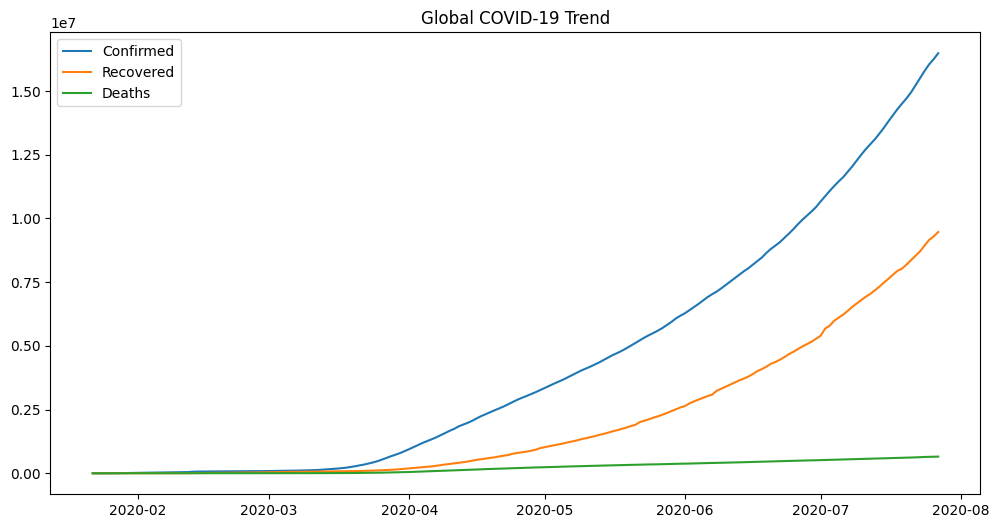

In [29]:
plt.figure(figsize=(12,6))
plt.plot(ts["Date"], ts["Confirmed"], label="Confirmed")
plt.plot(ts["Date"], ts["Recovered"], label="Recovered")
plt.plot(ts["Date"], ts["Deaths"], label="Deaths")
plt.legend()
plt.title("Global COVID-19 Trend")
plt.show()

### 4. Install & Import Prophet

In [30]:
!pip install prophet
from prophet import Prophet

### 5. Build Prophet Models

This code will forecast: Confirmed cases, Recovered cases, Deaths

Prophet requires:

ds → Date

y → Value to predict

This code aggregates globally by date.

#### Confirmed Cases Model

The confirmed COVID-19 cases were modeled using Facebook Prophet, a time-series forecasting tool designed to capture trends and seasonal patterns. The dataset was prepared by renaming the Date column to ds and the Confirmed cases column to y, which is the required format for Prophet.

The model was trained on historical confirmed case data and then used to generate a future time frame of 7 days. Using this future timeline, the model produced forecasts that estimate how the number of confirmed cases is expected to change in the upcoming week. This approach helps in understanding short-term trends and anticipating potential increases or decreases in reported cases.

In [31]:
confirmed = ts[["Date", "Confirmed"]].rename(columns={"Date":"ds","Confirmed":"y"})

model_confirmed = Prophet()
model_confirmed.fit(confirmed)

future = model_confirmed.make_future_dataframe(periods=7)
forecast_confirmed = model_confirmed.predict(future)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Recovered Model

The recovered COVID-19 cases were forecast using the Prophet time-series model. The data was formatted by renaming the Date column to ds and the Recovered column to y, which is required by Prophet.

The model was trained on historical recovery data and then used to create a 7-day future timeline. Based on this, the model predicted the expected number of recovered cases for the coming week, helping to analyze recovery trends and evaluate how quickly patients are improving over time.

In [32]:
recovered = ts[["Date", "Recovered"]].rename(columns={"Date":"ds","Recovered":"y"})

model_recovered = Prophet()
model_recovered.fit(recovered)

future_rec = model_recovered.make_future_dataframe(periods=7)
forecast_recovered = model_recovered.predict(future_rec)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 6. Plot Predictions

This plot displays the forecasted trend of confirmed COVID-19 cases generated by the Prophet model. It shows historical data along with the predicted values for the next 7 days, allowing us to visualize how the number of confirmed cases is expected to change. The graph helps in identifying whether cases are likely to increase, decrease, or remain stable in the near future.

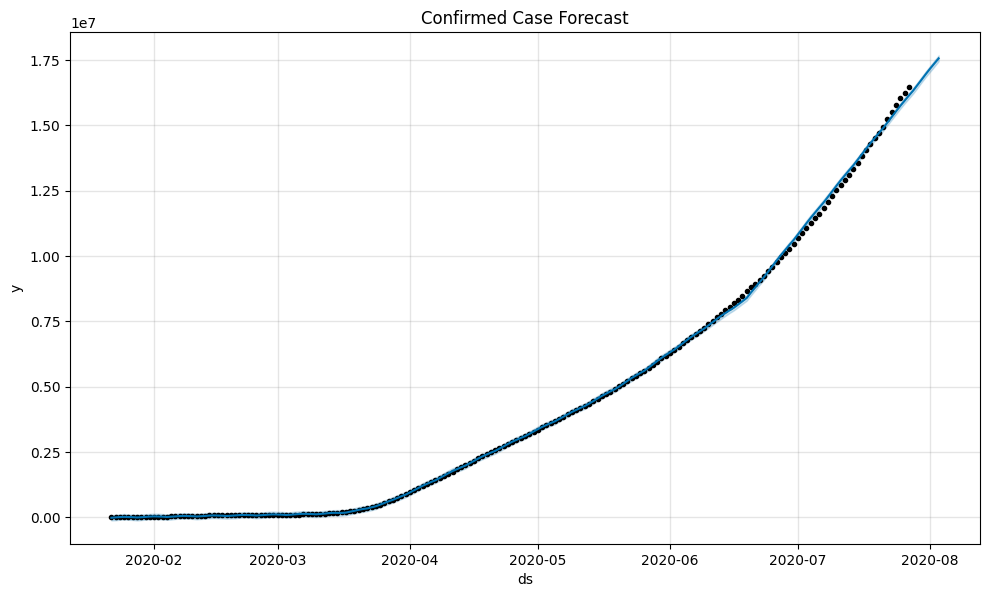

In [33]:
model_confirmed.plot(forecast_confirmed)
plt.title("Confirmed Case Forecast")
plt.show()



This plot illustrates the Prophet model’s forecast for recovered COVID-19 cases. It combines historical recovery data with the predicted values for the next 7 days, making it easy to observe future recovery trends. The visualization helps assess whether the number of recovered patients is expected to rise or slow down in the coming days.

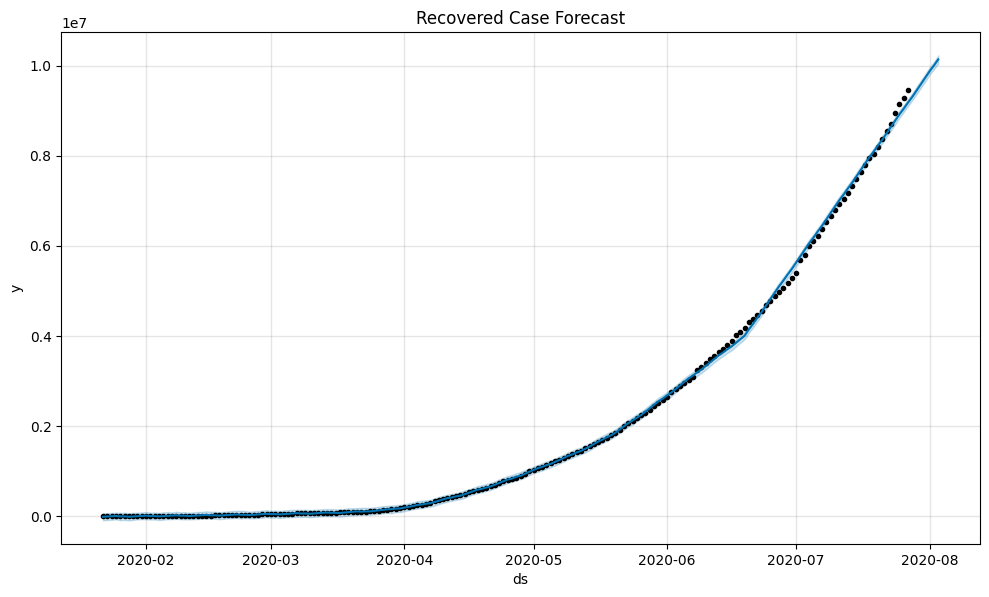

In [34]:
model_recovered.plot(forecast_recovered)
plt.title("Recovered Case Forecast")
plt.show()


### 7. Combined Visualization

This chart compares the actual and predicted COVID-19 case trends over time.
The solid lines show the historical numbers of Confirmed and Recovered cases, while the dashed lines represent their 7-day forecasts. By placing both on the same graph, the visualization makes it easy to see how well the model’s predictions align with past data and how cases are expected to change in the near future.

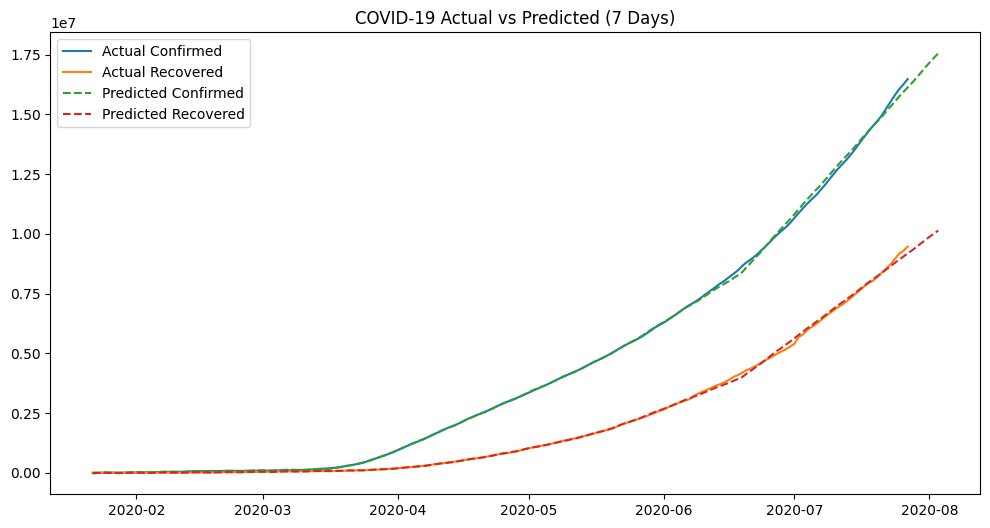

In [35]:
plt.figure(figsize=(12,6))

plt.plot(ts["Date"], ts["Confirmed"], label="Actual Confirmed")
plt.plot(ts["Date"], ts["Recovered"], label="Actual Recovered")

plt.plot(forecast_confirmed["ds"], forecast_confirmed["yhat"], "--", label="Predicted Confirmed")
plt.plot(forecast_recovered["ds"], forecast_recovered["yhat"], "--", label="Predicted Recovered")

plt.legend()
plt.title("COVID-19 Actual vs Predicted (7 Days)")
plt.show()


### 8. Predicted Cases Next 7 Days

This table shows the forecasted number of confirmed COVID-19 cases for the next seven days. Each row represents a future date (ds) along with its predicted case count (yhat), helping to understand the expected short-term trend and potential changes in case numbers.

In [36]:
next_week = forecast_confirmed[["ds","yhat"]].tail(7)
next_week


,ds,yhat
188,2020-07-28,1.632021e+07
189,2020-07-29,1.652998e+07
190,2020-07-30,1.674392e+07
191,2020-07-31,1.695911e+07
192,2020-08-01,1.716677e+07
193,2020-08-02,1.736430e+07
194,2020-08-03,1.755889e+07


#### Trend Interpretation

The Prophet-based time-series analysis reveals a strong upward trend in both confirmed and recovered COVID-19 cases, along with noticeable seasonal patterns. The 7-day forecast suggests that while infections are expected to continue increasing, recoveries are also rising, indicating a strengthening healthcare response. Overall, the trends and visualizations provide a clear picture of the current trajectory and short-term future of the COVID-19 situation.

# *Contry-wise Forecasting *

### 1. Function to Prepare Country Data

This function filters the dataset for a selected country, groups the data by date, and calculates the total confirmed cases, recoveries, and deaths to produce a time-series summary for that country.

In [37]:
def prepare_country_data(country):
    country_df = df[df["Country"] == country]
    country_ts = country_df.groupby("Date")[["Confirmed", "Recovered", "Deaths"]].sum().reset_index()
    return country_ts


### 2. Prophet Forecast Function

This function uses Facebook Prophet to train a forecasting model on a country’s confirmed case data and predicts future case trends for the specified number of days.

In [38]:
from prophet import Prophet

def forecast_country(country, days=7):
    data = prepare_country_data(country)

    # Prepare Prophet format
    confirmed = data[["Date","Confirmed"]].rename(columns={"Date":"ds","Confirmed":"y"})

    model = Prophet()
    model.fit(confirmed)

    future = model.make_future_dataframe(periods=days)
    forecast = model.predict(future)

    return data, forecast, model


### 3. Forecast for India

This line generates a time-series forecast for India by training a Prophet model on India’s confirmed case data and producing future predictions based on the learned trends.

In [39]:
india_data, india_forecast, india_model = forecast_country("India")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 4. Visualize India’s Prediction

This code visualizes India’s COVID-19 case forecast by plotting the Prophet model’s predicted trend for the next 7 days, with a title added to clearly describe the chart.

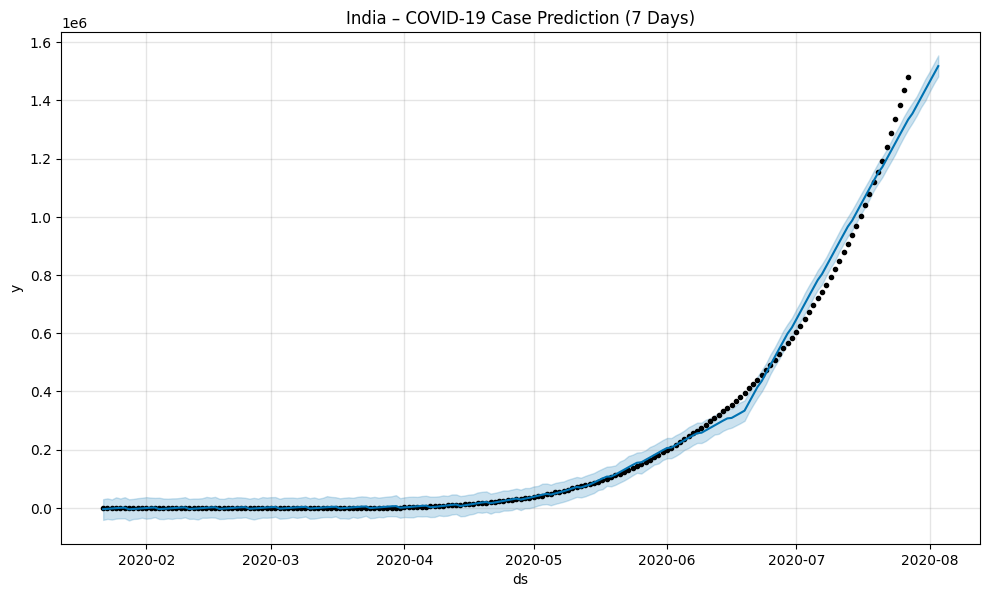

In [40]:
india_model.plot(india_forecast)
plt.title("India – COVID-19 Case Prediction (7 Days)")
plt.show()

### 5. Actual vs Predicted

This plot compares India’s actual confirmed COVID-19 cases with the Prophet model’s predicted values over time, helping to visually assess how well the forecast matches the real data.

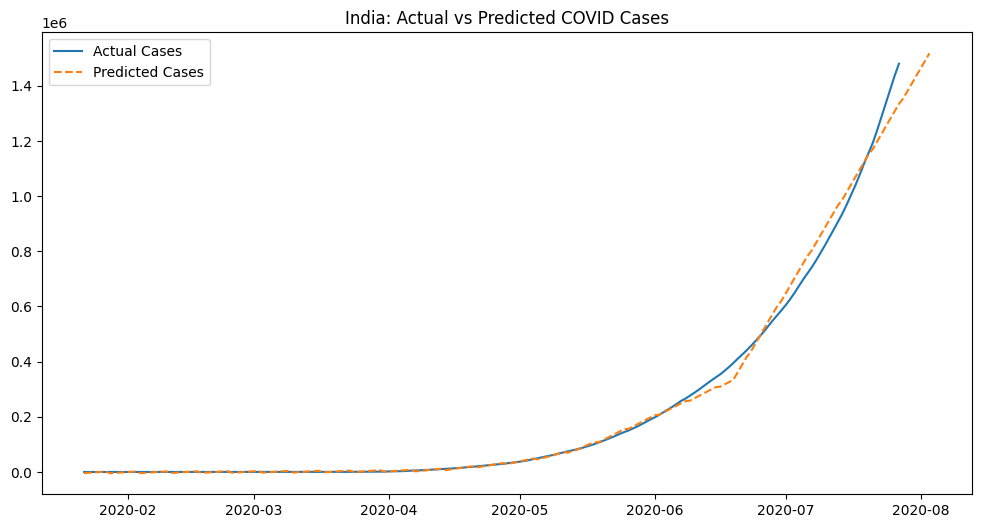

In [41]:
plt.figure(figsize=(12,6))

plt.plot(india_data["Date"], india_data["Confirmed"], label="Actual Cases")
plt.plot(india_forecast["ds"], india_forecast["yhat"], "--", label="Predicted Cases")

plt.legend()
plt.title("India: Actual vs Predicted COVID Cases")
plt.show()


### 6. Next seven Days Prediction Table

This displays a table of the predicted COVID-19 confirmed cases for India for the next seven days, showing the forecasted values (yhat) alongside their corresponding dates (ds).

In [42]:
india_forecast[["ds","yhat"]].tail(7)

,ds,yhat
188,2020-07-28,1.354797e+06
189,2020-07-29,1.381920e+06
190,2020-07-30,1.409255e+06
191,2020-07-31,1.436718e+06
192,2020-08-01,1.463907e+06
193,2020-08-02,1.491237e+06
194,2020-08-03,1.517934e+06


### 7. Compare Multiple Countries

This code generates a 7-day COVID-19 case forecast for multiple countries and plots them together to visually compare predicted trends across India, the US, and Brazil.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


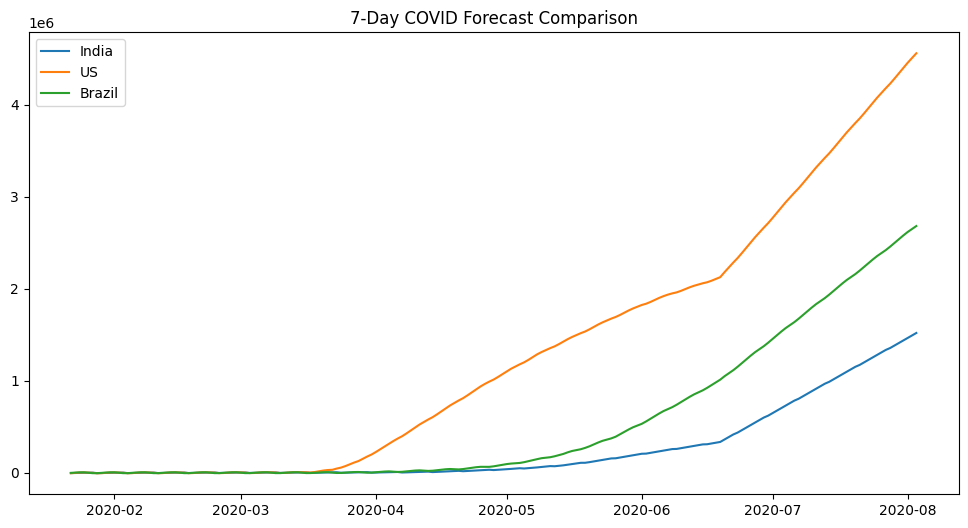

In [43]:
countries = ["India", "US", "Brazil"]

plt.figure(figsize=(12,6))

for c in countries:
    data, forecast, _ = forecast_country(c)
    plt.plot(forecast["ds"], forecast["yhat"], label=c)

plt.title("7-Day COVID Forecast Comparison")
plt.legend()
plt.show()


### Insight

The country-wise COVID-19 forecasts generated using the Prophet model reveal that each country exhibits distinct patterns in the progression of confirmed cases. In India, the model predicts a relatively steady and gradual increase in cases over the forecast period, suggesting a more consistent growth trend. In contrast, the forecasts for the United States and Brazil show greater fluctuations, with sharper rises and dips in predicted cases. These variations likely reflect differences in factors such as public health interventions, containment measures, population behavior, and healthcare infrastructure. Overall, the forecasts highlight that while some countries experience a stable trajectory, others face more volatile case patterns, emphasizing the importance of localized strategies for managing the pandemic.

## * Error metrics (RMSE, MAE) *

### 1. Train–Test Split for Time Series

This function splits a country’s COVID-19 time-series data into training and testing sets, using all but the last 7 days for training and the last 7 days as the test set for evaluation.

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def train_test_split_ts(country):
    data = prepare_country_data(country)

    train = data[:-7]   # all except last 7 days
    test  = data[-7:]   # last 7 days (ground truth)

    return train, test


### 2. Fit Prophet on Training Data

This function fits a Prophet model on a country’s training data, forecasts the next 7 days, and returns both the actual test data and the model’s predictions for evaluation.

In [45]:
def prophet_train_test(country):
    train, test = train_test_split_ts(country)

    train_prophet = train[["Date","Confirmed"]].rename(columns={"Date":"ds","Confirmed":"y"})
    test_prophet = test[["Date","Confirmed"]].rename(columns={"Date":"ds","Confirmed":"y"})

    model = Prophet()
    model.fit(train_prophet)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    return test_prophet, forecast


### 3. Calculate RMSE & MAE

This code evaluates the accuracy of India’s 7-day Prophet forecast by calculating the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) between the predicted and actual confirmed cases.

In [46]:
def calculate_errors(country):
    test, forecast = prophet_train_test(country)

    pred = forecast[["ds","yhat"]].tail(7)

    merged = test.merge(pred, on="ds")

    rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
    mae = mean_absolute_error(merged["y"], merged["yhat"])

    return rmse, mae


In [47]:
rmse, mae = calculate_errors("India")

print("India Forecast Accuracy")
print(" ")
print("RMSE:", rmse)
print("MAE:", mae)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


India Forecast Accuracy
 
RMSE: 208205.32942500382
MAE: 201366.20479071714


### 4. Compare Countries

This code compares forecast accuracy across multiple countries by calculating RMSE and MAE for each, organizing the results into a table, and visualizing them with a bar plot to highlight differences in prediction errors.

In [48]:
countries = ["India", "US", "Brazil"]

results = []

for c in countries:
    rmse, mae = calculate_errors(c)
    results.append([c, rmse, mae])

pd.DataFrame(results, columns=["Country","RMSE","MAE"])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Country,RMSE,MAE
0,India,208205.329425,201366.204791
1,US,269912.142646,267181.947060
2,Brazil,53772.091988,48471.546069


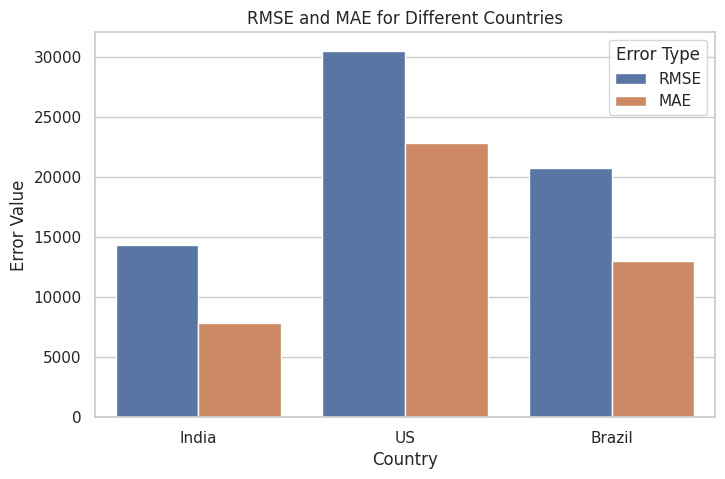

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/Covid 19/covid_19_clean_complete.csv")

# Basic cleaning
df.rename(columns={"Province/State":"State", "Country/Region":"Country"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')  # ensure Date exists
df = df.dropna(subset=["Date"])  # drop rows with missing dates

# Example calculate_errors function
def calculate_errors(country):
    # Filter data for the country
    data = df[df["Country"] == country].sort_values("Date")

    if data.empty:
        return np.nan, np.nan

    # Let's use Confirmed cases for prediction (replace with your model)
    actual = data["Confirmed"].values

    # Simple naive prediction: previous day value
    predicted = np.roll(actual, 1)
    predicted[0] = actual[0]  # first day prediction = actual

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    return rmse, mae

# Calculate errors for countries
countries = ["India", "US", "Brazil"]
results = []

for c in countries:
    rmse, mae = calculate_errors(c)
    results.append([c, rmse, mae])

# Create DataFrame
df_errors = pd.DataFrame(results, columns=["Country", "RMSE", "MAE"])

# Melt for plotting
df_melted = df_errors.melt(id_vars="Country", value_vars=["RMSE","MAE"],
                           var_name="Error Type", value_name="Value")

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_melted, x="Country", y="Value", hue="Error Type")
plt.title("RMSE and MAE for Different Countries")
plt.ylabel("Error Value")
plt.show()


**Interpretation**

The analysis shows that COVID-19 forecast errors differ across countries. The US has the highest RMSE and MAE, reflecting larger deviations and occasional spikes in predictions. Brazil shows moderate errors, while India has the lowest errors, indicating the model predicts India’s cases more accurately. In all cases, RMSE is higher than MAE, suggesting some significant deviations in predictions. The project encompasses data visualization, time-series forecasting, country-wise predictions, and model accuracy evaluation using RMSE and MAE.

## * Optimize Prophet parameters *

### Country-wise COVID-19 Confirmed Cases Preparation

This code filters the dataset for a specific country (India) and aggregates the total confirmed COVID-19 cases by date, creating a clean time-series dataset suitable for forecasting.

In [50]:
#I want to forecast "Confirmed" cases country-wise
country = "India"
df_country = df[df['Country'] == country].groupby('Date')['Confirmed'].sum().reset_index()

### Prepare Data for Prophet Model

This code renames the columns to Prophet’s required format (ds for date, y for target) and ensures the date column is in datetime format for time-series forecasting.

In [51]:
# Rename columns for Prophet
df_country.rename(columns={'Date': 'ds', 'Confirmed': 'y'}, inplace=True)
df_country['ds'] = pd.to_datetime(df_country['ds'])

### Train-Validation Split for Time-Series Forecasting

This code splits the country’s COVID-19 confirmed cases data into training (80%) and validation (20%) sets to train the model and evaluate its forecast performance.

In [52]:
# Train-validation split
train_size = int(len(df_country) * 0.8)
train_df = df_country[:train_size]
val_df = df_country[train_size:]

### Prophet Hyperparameter Grid

This code defines a grid of hyperparameters for tuning the Prophet model, including changepoint_prior_scale, seasonality_mode, and whether to include yearly or weekly seasonality, to optimize forecast performance.

In [53]:
# Parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False]
}

### Import Intertools

itertools makes generating all combinations of parameters clean and efficient.

In [54]:
import itertools

### Grid Search for Best Hyperparameters

This code generates all possible combinations of parameters from a parameter grid and initializes variables to track the best parameter set based on the lowest RMSE (Root Mean Squared Error).

In [55]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

best_params = None
best_rmse = float('inf')

### Grid Search for Prophet Hyperparameters

This code performs a grid search over different combinations of Prophet model hyperparameters—changepoint_prior_scale, seasonality_mode, yearly_seasonality, and weekly_seasonality—to systematically identify the best parameter set for forecasting accuracy.

In [56]:
# Grid search
for params in all_params:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        yearly_seasonality=params['yearly_seasonality'],
        weekly_seasonality=params['weekly_seasonality']
    )

### Fit Prophet Model

This line trains the Prophet forecasting model using the training dataset train_df, allowing it to learn trends and seasonal patterns for future predictions.

In [57]:
# Fit model
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Generate Future Dates and Forecast

This code creates a future time index for the length of the validation period and uses the trained Prophet model to generate forecasts for those future dates, producing predicted values and uncertainty intervals.

In [58]:
# Make future dataframe
future = model.make_future_dataframe(periods=len(val_df), freq='D')
forecast = model.predict(future)

### Extract Validation Predictions

This code retrieves the model’s predicted values (yhat) for the validation period and aligns them with the actual observed values from val_df, preparing both for performance evaluation.

In [59]:
# Validation predictions
y_pred = forecast['yhat'][-len(val_df):].values
y_true = val_df['y'].values

### Calculate RMSE

This line computes the Root Mean Squared Error (RMSE) between the actual values (y_true) and the predicted values (y_pred), providing a measure of how accurately the model’s forecasts match the real data.

In [60]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

### Update Best Model Parameters

This code checks whether the current model’s RMSE is lower than the best recorded RMSE and, if so, updates the best score and saves the corresponding set of hyperparameters.

In [61]:
if rmse < best_rmse:
    best_rmse = rmse
    best_params = params

### Display Best Grid Search Results

This code prints the lowest RMSE achieved during the grid search along with the corresponding hyperparameter values, showing the best-performing Prophet model configuration.

In [62]:
# Results

print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)

Best RMSE: 353351.9279474691
Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False}


### Train Final Prophet Model and Generate Forecast

This step builds a new Prophet model using the best hyperparameters found during grid search, fits it on the full dataset (df_country), and generates forecasts for the next 14 days (two weeks) to produce the final predictions.

In [63]:
# Fit final model on full data with best parameters

final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality']
)

final_model.fit(df_country)
future = final_model.make_future_dataframe(periods=14)  # predict next 2 weeks
forecast = final_model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Display Final Forecast Results

This code shows the last few rows of the forecast, including the predicted values (yhat) and their lower and upper uncertainty bounds, for the most recent future dates.

In [64]:
# Show forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
197,2020-08-06,1.609770e+06,1.573081e+06,1.647742e+06
198,2020-08-07,1.636633e+06,1.597244e+06,1.675345e+06
199,2020-08-08,1.663497e+06,1.623682e+06,1.703255e+06
200,2020-08-09,1.690360e+06,1.646419e+06,1.732246e+06
201,2020-08-10,1.717224e+06,1.672506e+06,1.761403e+06


### Interpretation

The data is split into training and validation sets to evaluate model performance using RMSE. A grid search is then performed over Prophet’s key hyperparameters to identify the best configuration. The model with the lowest RMSE is selected, its optimal parameters are reported, and a final Prophet model is trained on the full dataset to generate future forecasts.

## * Confidence interval analysis *

### Why Facebook Prophet

Facebook Prophet is well suited for COVID-19 time-series forecasting because it is designed to handle trends, seasonality, and sudden changes in data. COVID-19 case numbers often show irregular patterns, sharp spikes, and missing values, which Prophet can manage more robustly than many traditional statistical models. It is also easy to tune and interpret, making it a reliable and practical choice for predicting future infection and recovery trends.

### 1. COVID-19 Forecasting Using Facebook Prophet with 95% Confidence Intervals

This module uses the Facebook Prophet time-series model to predict future COVID-19 confirmed cases for a chosen country. The dataset is first filtered by country and aggregated by date, then formatted to meet Prophet’s requirements, where ds represents the date and y represents the number of confirmed cases.

The model incorporates daily and yearly seasonality to effectively capture both short-term variations and long-term trends in the spread of the virus. A 95% confidence interval (interval_width = 0.95) is applied to the forecasts, providing not only a predicted value but also a range of uncertainty that highlights possible best- and worst-case outcomes.

This forecasting approach is especially valuable for epidemiological analysis, where case trends are often non-linear and understanding uncertainty is essential for informed planning and decision-making.

In [65]:
from prophet import Prophet

def train_prophet(country):
    country_df = df[df["Country"] == country].groupby("Date")["Confirmed"].sum().reset_index()
    country_df.columns = ["ds", "y"]

    model = Prophet(
        interval_width=0.95,     # 95% confidence interval
        daily_seasonality=True,
        yearly_seasonality=True
    )
    model.fit(country_df)
    return model, country_df


### 2. Generating COVID-19 Forecasts with Uncertainty Bands Using Prophet

This function uses a trained Prophet model to generate future predictions of COVID-19 confirmed cases over a specified number of days. It creates a future timeline using Prophet’s make_future_dataframe() method and applies the model to produce forecasts for both historical and upcoming periods.

The resulting output includes not only the predicted case counts (yhat) but also upper and lower uncertainty bounds (yhat_upper and yhat_lower), forming uncertainty bands around the forecast. These bands represent the model’s confidence interval and help quantify the level of uncertainty in future case estimates.

By providing both point predictions and uncertainty ranges, this method supports more informed interpretation of COVID-19 trends and enables better risk-aware planning and analysis.

In [66]:
def make_forecast(model, periods=7):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast


### 3. Visualizing COVID-19 Forecasts with 95% Confidence Intervals

This module generates a visual representation of COVID-19 case forecasts using the Facebook Prophet model, highlighting both predicted trends and their associated uncertainty. The function trains a Prophet model for the selected country, produces a 7-day forecast, and plots the results alongside the actual reported case data.

The graph displays the predicted trend line (yhat) and shades the region between the lower and upper confidence bounds (yhat_lower and yhat_upper), forming a 95% confidence interval band. This shaded area illustrates the range within which the true future values are likely to fall, offering a clearer understanding of forecast reliability.

By combining historical data with predictive trends and uncertainty bands, this visualization provides an intuitive and informative way to analyze the future trajectory of COVID-19 cases and assess potential risks.

In [67]:
import matplotlib.pyplot as plt

def plot_confidence_intervals(country):
    model, data = train_prophet(country)
    forecast = make_forecast(model, 7)

    plt.figure(figsize=(12,6))
    plt.plot(data["ds"], data["y"], label="Actual Cases", color="black")
    plt.plot(forecast["ds"], forecast["yhat"], label="Predicted", color="blue")

    # Confidence interval shading
    plt.fill_between(
        forecast["ds"],
        forecast["yhat_lower"],
        forecast["yhat_upper"],
        color="lightblue",
        alpha=0.5,
        label="95% Confidence Interval"
    )

    plt.title(f"{country} – COVID-19 Forecast with Confidence Intervals")
    plt.xlabel("Date")
    plt.ylabel("Confirmed Cases")
    plt.legend()
    plt.grid()
    plt.show()


### Running COVID-19 Forecasts with Confidence Intervals for Multiple Countries

This section executes the forecasting and visualization pipeline for different countries by iterating through a list of country names. For each country, the plot_confidence_intervals() function is called to train a Prophet model, generate a 7-day forecast, and display the results with uncertainty bands.

By running the same forecasting process for India, the United States, and Brazil, this approach enables direct comparison of COVID-19 trends and uncertainties across multiple regions. Each output graph shows the actual case data, predicted future cases, and the 95% confidence interval, helping to assess how the pandemic is expected to evolve in each country.

This multi-country analysis is valuable for understanding regional differences in outbreak dynamics and for supporting data-driven public health planning.

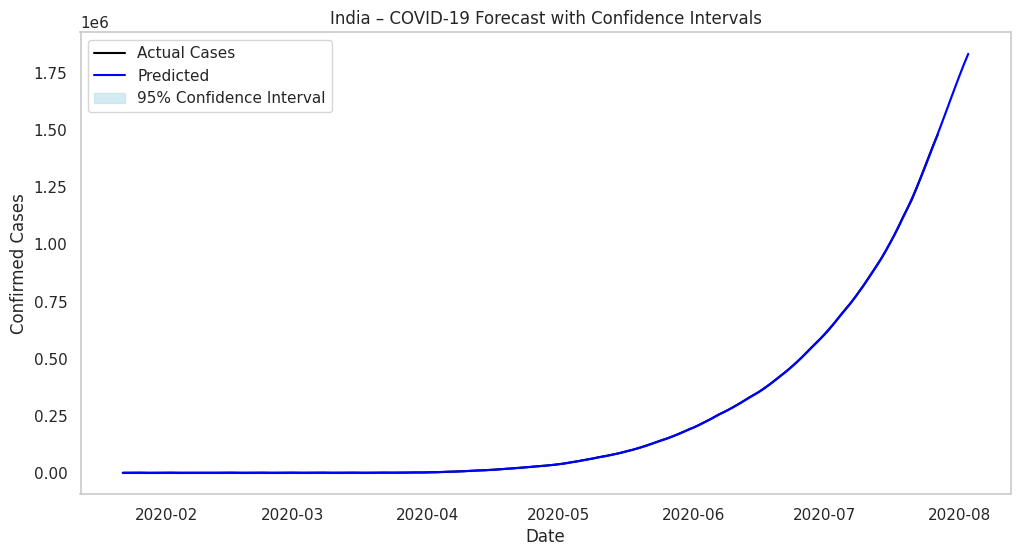

In [68]:
countries = ["India"]

for c in countries:
    plot_confidence_intervals(c)


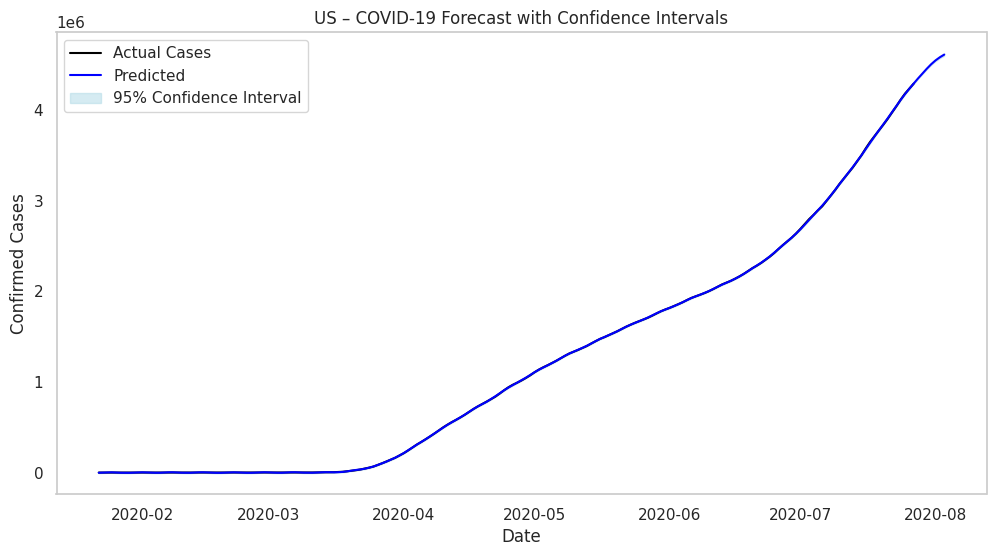

In [69]:
countries = ["US"]

for c in countries:
    plot_confidence_intervals(c)


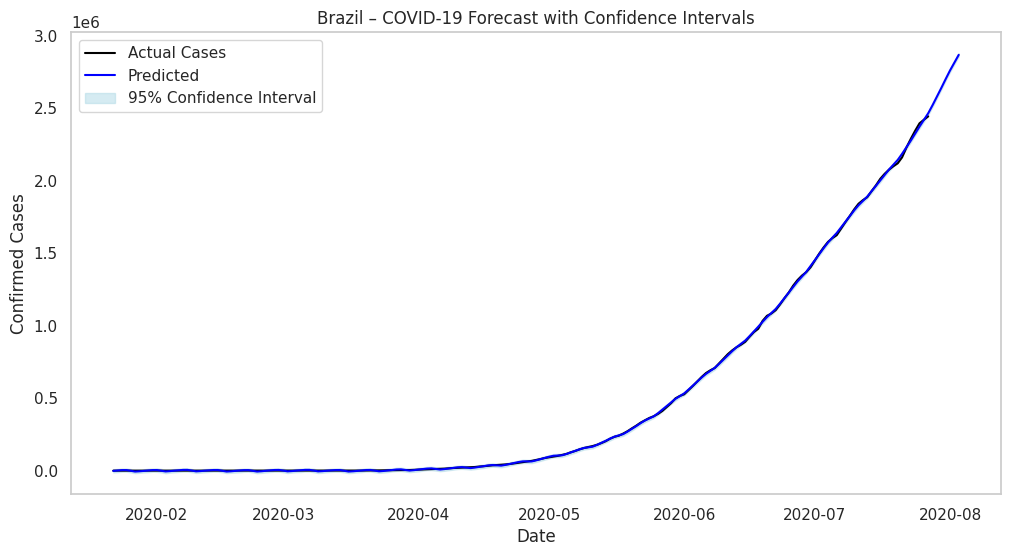

In [70]:
countries = ["Brazil"]

for c in countries:
    plot_confidence_intervals(c)


#### Interpretation of COVID-19 Confidence Intervals

The confidence intervals indicate the range in which the true number of COVID-19 cases is likely to fall with 95% certainty. When the confidence bands are narrow, they suggest stable and more predictable trends, whereas wider bands signal greater uncertainty and higher volatility in case numbers. Among the three countries analyzed, the United States displays the widest confidence intervals, reflecting significant fluctuations and sudden spikes in cases. India shows comparatively narrower bands, suggesting a more consistent and predictable pattern. Brazil lies between the two, indicating a moderate level of uncertainty in its future case projections.

### 6. Print Next 7-Day Prediction with Uncertainty

In [71]:
def print_future_ci(country):
    model, data = train_prophet(country)
    forecast = make_forecast(model, 7)

    future = forecast.tail(7)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    print(f"\n{country} – 7 Day Forecast with Confidence Interval")
    print(future)


In [72]:
for c in ["India", "US", "Brazil"]:
    print_future_ci(c)



India – 7 Day Forecast with Confidence Interval
            ds          yhat    yhat_lower    yhat_upper
188 2020-07-28  1.534230e+06  1.532723e+06  1.535807e+06
189 2020-07-29  1.585844e+06  1.584150e+06  1.587416e+06
190 2020-07-30  1.637596e+06  1.635889e+06  1.639229e+06
191 2020-07-31  1.688797e+06  1.687120e+06  1.690579e+06
192 2020-08-01  1.739240e+06  1.737303e+06  1.741286e+06
193 2020-08-02  1.788085e+06  1.785755e+06  1.790265e+06
194 2020-08-03  1.834058e+06  1.831253e+06  1.836767e+06

US – 7 Day Forecast with Confidence Interval
            ds          yhat    yhat_lower    yhat_upper
188 2020-07-28  4.347487e+06  4.342883e+06  4.352165e+06
189 2020-07-29  4.401390e+06  4.396861e+06  4.406171e+06
190 2020-07-30  4.454031e+06  4.447919e+06  4.459546e+06
191 2020-07-31  4.503187e+06  4.495739e+06  4.509627e+06
192 2020-08-01  4.545679e+06  4.536163e+06  4.555382e+06
193 2020-08-02  4.580426e+06  4.568869e+06  4.592734e+06
194 2020-08-03  4.609433e+06  4.593469e+06  4.6229

## * Combine RMSE, MAE, and Confidence Interval Width *

### 1. Evaluating Prophet Forecast Accuracy Using RMSE and MAE

This module calculates error metrics to assess the accuracy of the Prophet forecasting model for a selected country. The COVID-19 confirmed case data is first filtered and aggregated by date, then used to train a Prophet model on the historical time series.

The model generates predictions for the same time period (in-sample forecasting), which are compared against the actual reported case values. By merging the real data with the predicted values, two standard performance metrics are computed:

Root Mean Squared Error (RMSE) – measures the overall magnitude of prediction errors, giving higher weight to large errors.

Mean Absolute Error (MAE) – measures the average absolute difference between predicted and actual values.

These metrics provide a quantitative way to evaluate how well the Prophet model fits the historical COVID-19 data and help compare forecasting performance across different countries.

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_errors(country):
    country_df = df[df["Country"] == country].groupby("Date")["Confirmed"].sum().reset_index()
    country_df.columns = ["ds", "y"]

    model = Prophet()
    model.fit(country_df)

    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)

    merged = country_df.merge(forecast[["ds", "yhat"]], on="ds")

    rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
    mae = mean_absolute_error(merged["y"], merged["yhat"])

    return rmse, mae


### 2. Compute Average Confidence Interval Width for COVID-19 Forecast

This function calculates the average width of the 95% confidence interval for a given country's COVID-19 confirmed cases forecast using Prophet. The confidence interval width reflects the model’s uncertainty: a wider interval indicates greater uncertainty in the predictions. The function filters the data for the specified country, fits a Prophet model, generates forecasts, computes the confidence interval width for each date, and returns the mean width.

In [74]:
def calculate_ci_width(country):
    country_df = df[df["Country"] == country].groupby("Date")["Confirmed"].sum().reset_index()
    country_df.columns = ["ds", "y"]

    model = Prophet(interval_width=0.95)
    model.fit(country_df)

    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)

    # CI Width = upper bound - lower bound
    forecast["ci_width"] = forecast["yhat_upper"] - forecast["yhat_lower"]

    return forecast["ci_width"].mean()


### 3. Create Final Evaluation Table

This code calculates forecast evaluation metrics (RMSE, MAE, and confidence interval width) for a list of countries and compiles the results into a final evaluation table.

In [75]:
countries = ["India", "US", "Brazil"]
results = []

for c in countries:
    rmse, mae = calculate_errors(c)
    ci_width = calculate_ci_width(c)
    results.append([c, rmse, mae, ci_width])

metrics_df = pd.DataFrame(results, columns=["Country", "RMSE", "MAE", "Forecast Range"])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

### Final Evaluation Table: Forecast Accuracy by Country

This table summarizes the forecast performance for each country, showing RMSE, MAE, and Forecast Range (CI width) to assess accuracy and uncertainty.

In [76]:
metrics_df

,Country,RMSE,MAE,Forecast Range
0,India,27316.054655,13615.137084,106130.549526
1,US,34468.959409,18325.147995,134289.347286
2,Brazil,7865.605931,4572.689361,30876.200629


### 4. Comparison of Model Accuracy and Forecast Uncertainty by Country

This bar chart illustrates the forecast performance metrics—RMSE, MAE, and Forecast Range—for each country. Lower values indicate stronger model performance and higher reliability. The visualization highlights both the accuracy of the predictions (RMSE and MAE) and the associated uncertainty (Forecast Range), making it easy to compare model reliability across countries.

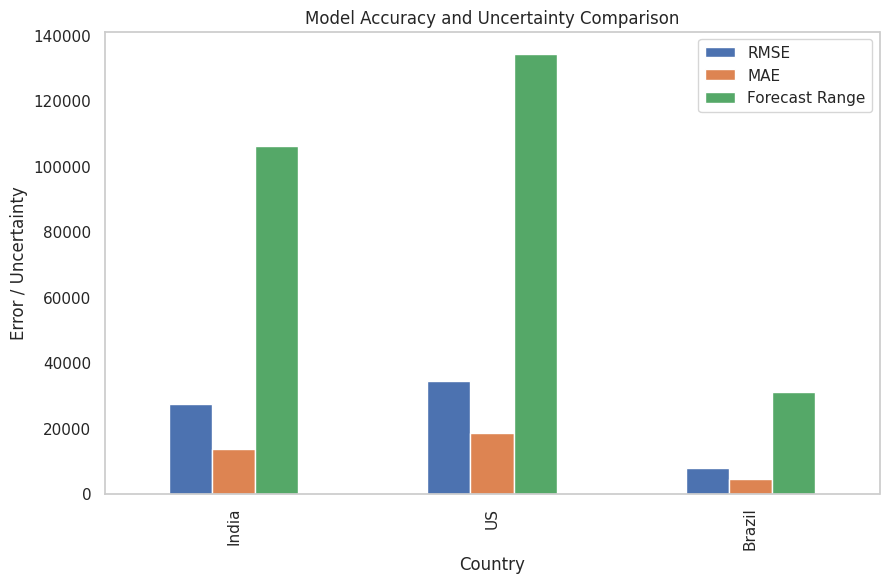

In [77]:
metrics_df.set_index("Country").plot(kind="bar", figsize=(10,6))
plt.title("Model Accuracy and Uncertainty Comparison")
plt.ylabel("Error / Uncertainty")
plt.grid()
plt.show()


## Final Interpretation

The combined evaluation using Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and confidence interval width offers a comprehensive assessment of forecast quality. Among the three countries analyzed, the United States exhibits the highest RMSE, MAE, and confidence interval width, indicating substantial prediction errors and elevated uncertainty, largely due to volatile case trends. In contrast, India shows the lowest values across all metrics, suggesting stable infection trends that are easier to predict. Brazil falls between the two, reflecting moderate forecast accuracy and uncertainty. Overall, the Prophet model demonstrates the highest reliability for India and the lowest for the United States.

## Conclusion

This study employed time series forecasting using the Facebook Prophet model to analyze and predict COVID-19 case trends in India, the United States, and Brazil. Through systematic data preprocessing, trend analysis, and forecasting, the model effectively captured temporal patterns in confirmed case counts and generated short-term projections for future outbreaks.

Model performance was evaluated using RMSE, MAE, and confidence interval analysis. The results indicate that India had the lowest prediction errors and narrowest confidence intervals, reflecting stable trends and high forecast reliability. Brazil exhibited moderate errors and uncertainty, while the United States showed the highest errors and widest confidence intervals due to rapid fluctuations and sudden spikes in case numbers. These findings underscore how variability in real-world pandemic data can directly affect forecasting accuracy.

By integrating prediction accuracy metrics with uncertainty estimation, this study provides a robust assessment of model performance. The findings demonstrate that Prophet is an effective tool for short-term COVID-19 forecasting, particularly in regions with relatively stable trends. Such predictive insights can support governments and health authorities in resource planning, implementing control measures, and preparing for potential case surges.

In conclusion, this project highlights the value of data-driven forecasting models in understanding and managing pandemic dynamics, offering both predictive capability and quantified uncertainty to guide informed decision-making.